In [3]:
import pandas as pd
import xarray as xr
import numpy as np
from pathlib import Path

class TyphoonDataProcessor:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.temp_data_path = self.base_path / "海洋温度数据(air.2m.gauss.1948)"
        self.typhoon_path = self.base_path / "附件1：中国近海台风路径集合(1945-2023)" / "1945-2023.xlsx"
        self.precip_path = self.base_path / "降水量统计数据"
        
    def load_typhoon_data(self):
        """加载台风路径数据"""
        print("正在加载台风路径数据...")
        try:
            typhoon_df = pd.read_excel(self.typhoon_path)
            print(f"台风数据加载成功，共 {len(typhoon_df)} 条记录")
            print("\n数据预览:")
            print(typhoon_df.head())
            print("\n数据列信息:")
            print(typhoon_df.info())
            return typhoon_df
        except Exception as e:
            print(f"加载台风数据时出错: {e}")
            return None
            
    def load_temperature_data(self, year):
        """加载指定年份的温度数据"""
        file_path = self.temp_data_path / f"air.2m.gauss.{year}.nc"
        try:
            temp_data = xr.open_dataset(file_path)
            print(f"\n{year}年温度数据加载成功")
            print("数据维度:", temp_data.dims)
            return temp_data
        except Exception as e:
            print(f"加载{year}年温度数据时出错: {e}")
            return None
            
    def load_precipitation_data(self):
        """加载降水量数据"""
        print("\n正在加载降水量数据...")
        precip_data = {}
        try:
            for file_path in self.precip_path.glob("*.csv"):
                df = pd.read_csv(file_path)
                precip_data[file_path.stem] = df
                print(f"已加载 {file_path.name}，共 {len(df)} 条记录")
            return precip_data
        except Exception as e:
            print(f"加载降水量数据时出错: {e}")
            return None

# 创建数据处理器实例
data_processor = TyphoonDataProcessor("D:/33249/Typhoon-prediction-model")

# 加载并预览数据
typhoon_data = data_processor.load_typhoon_data()
temp_data_2023 = data_processor.load_temperature_data(2023)  # 加载2023年的温度数据作为示例
precip_data = data_processor.load_precipitation_data()

正在加载台风路径数据...
台风数据加载成功，共 69130 条记录

数据预览:
     台风编号 台风中文名称 台风英文名称               台风起始时间               台风结束时间  \
0  194501      -      -  1945-04-19T12:00:00  1945-04-26T12:00:00   
1  194501      -      -  1945-04-19T12:00:00  1945-04-26T12:00:00   
2  194501      -      -  1945-04-19T12:00:00  1945-04-26T12:00:00   
3  194501      -      -  1945-04-19T12:00:00  1945-04-26T12:00:00   
4  194501      -      -  1945-04-19T12:00:00  1945-04-26T12:00:00   

                当前台风时间     经度   纬度      台风强度  台风等级    风速  气压 移动方向  移动速度  
0  1945-04-19T12:00:00  160.3  9.5  热带低压(TD)   6.0  12.0 NaN  NaN   NaN  
1  1945-04-19T18:00:00  159.9  9.6  热带低压(TD)   7.0  15.0 NaN  NaN   NaN  
2  1945-04-20T00:00:00  159.7  9.6  热带低压(TD)   7.0  17.0 NaN  NaN   NaN  
3  1945-04-20T06:00:00  159.3  9.7  热带风暴(TS)   8.0  20.0 NaN  NaN   NaN  
4  1945-04-20T12:00:00  158.8  9.8  热带风暴(TS)   9.0  23.0 NaN  NaN   NaN  

数据列信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69130 entries, 0 to 69129
Data columns (t

开始处理台风数据...

台风数据统计分析:

每年台风数量:

年度台风数量统计:
平均数: 22.95
标准差: 4.55
最小值: 12
最大值: 34


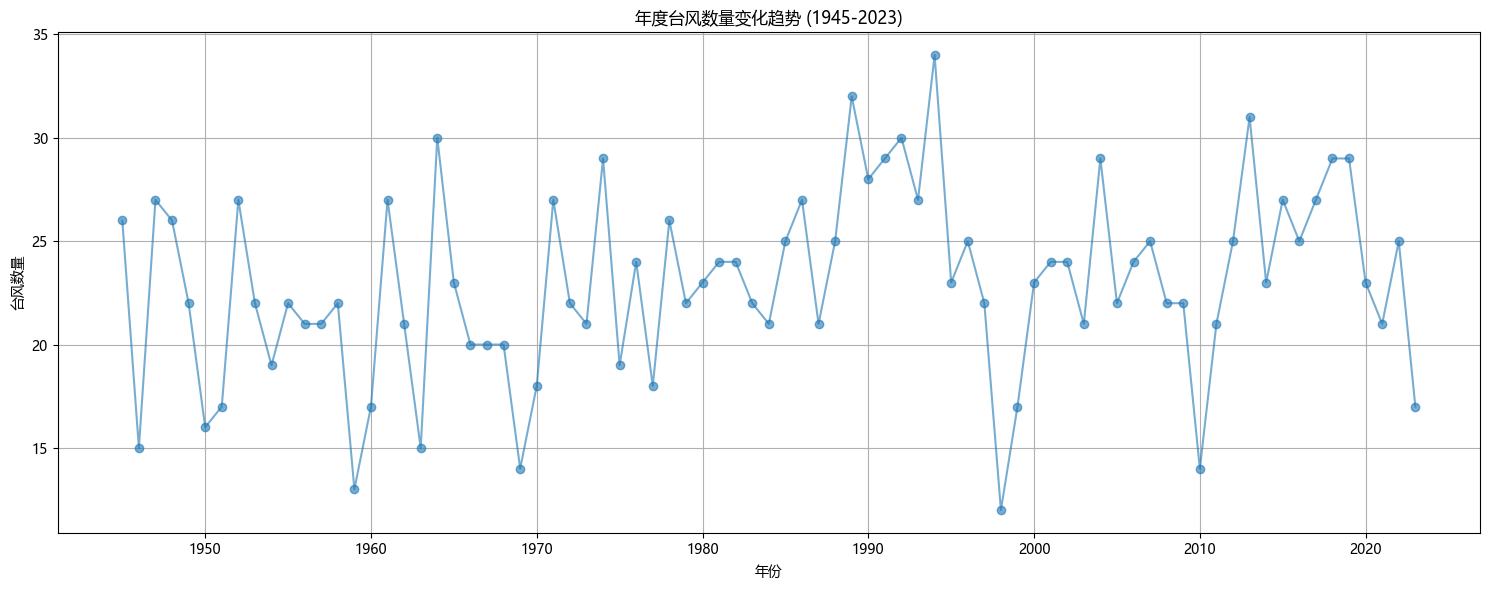


分析台风强度分布...

台风强度分布:
台风强度
台风(TY)            12117
强台风(STY)           6781
强热带风暴(STS)        13790
热带低压(TD)          10253
热带风暴(TS)          15524
超强台风(Super TY)     5061
Name: count, dtype: int64


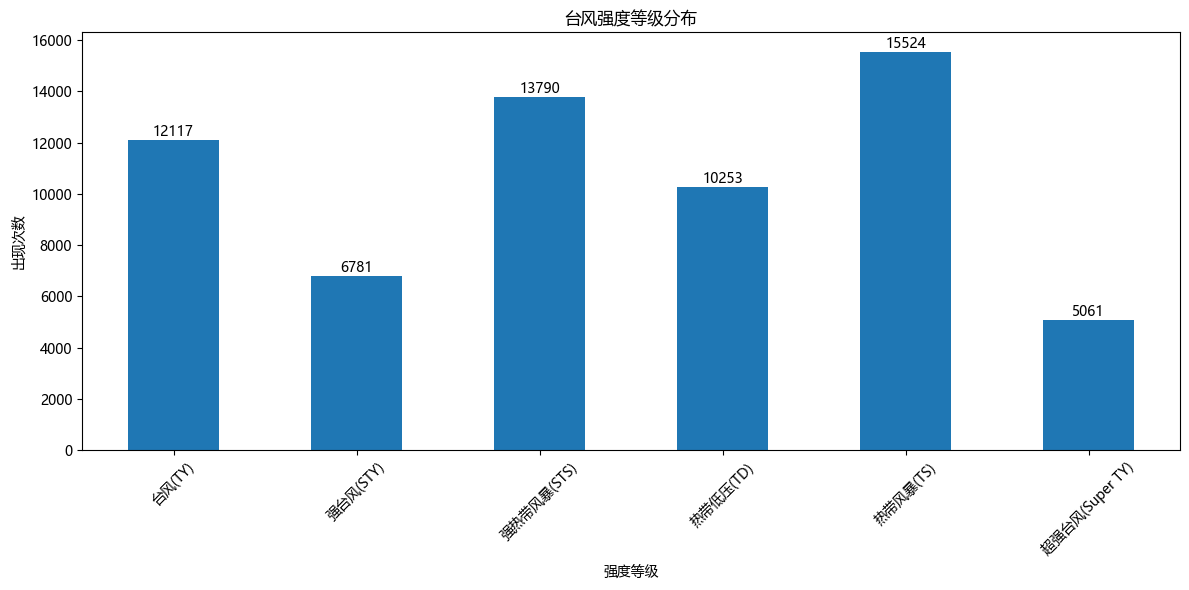

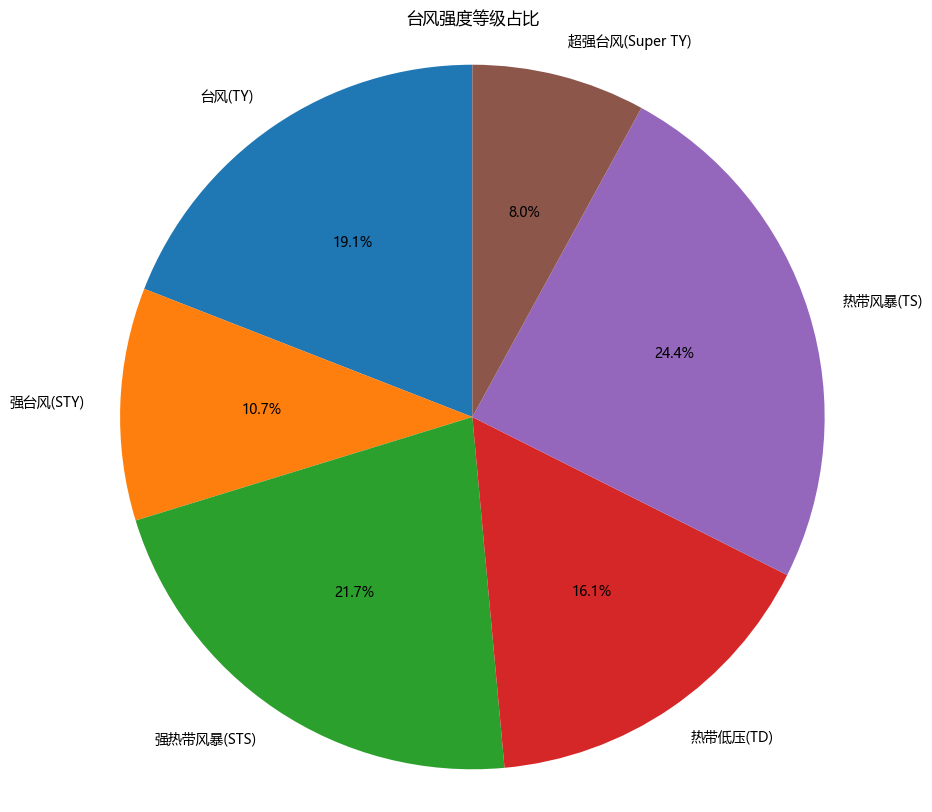


分析台风空间分布...


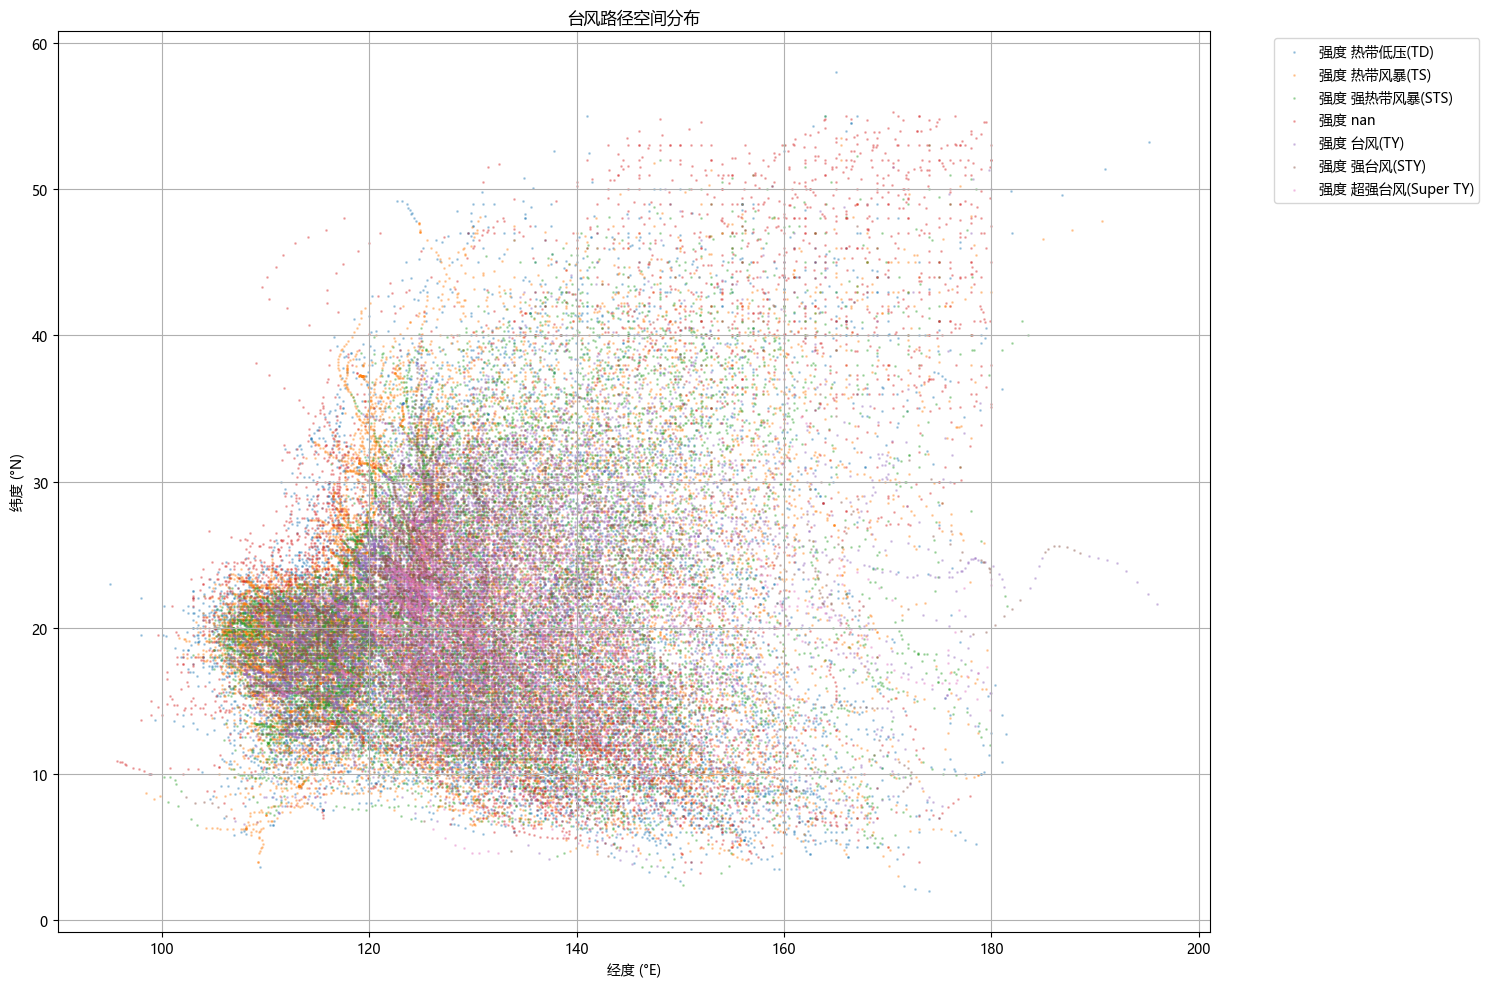

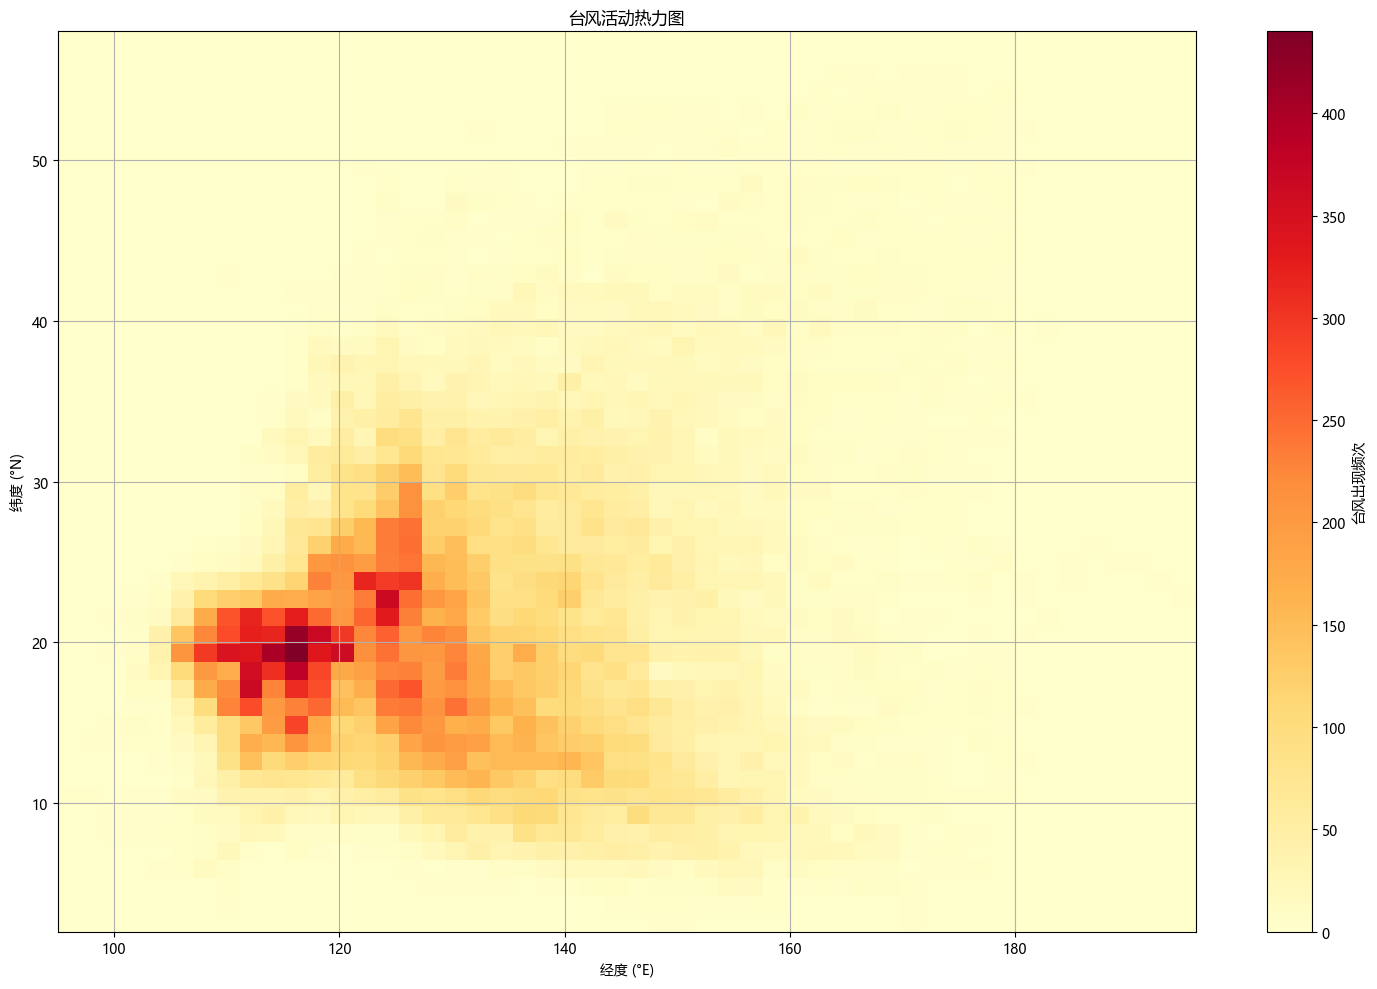


准备模型训练数据...

准备好的训练数据:
输入序列形状: (51229, 10, 5)
目标值形状: (51229, 5)

使用的特征: 经度, 纬度, 台风等级, 风速, 气压


In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
def set_chinese_font():
    """设置中文字体"""
    try:
        # 优先尝试微软雅黑
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False
    except:
        try:
            # 尝试黑体
            plt.rcParams['font.sans-serif'] = ['SimHei']
            plt.rcParams['axes.unicode_minus'] = False
        except:
            print("警告: 未能找到合适的中文字体，图表中的中文可能无法正常显示")

# 在文件开始时调用
set_chinese_font()

class TyphoonDataAnalyzer:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.typhoon_data = None
        self.precip_data = {}
        self.scaler = StandardScaler()
        
    def process_typhoon_data(self):
        """处理台风数据"""
        # 读取数据
        typhoon_path = self.base_path / "附件1：中国近海台风路径集合(1945-2023)" / "1945-2023.xlsx"
        self.typhoon_data = pd.read_excel(typhoon_path)
        
        # 转换时间列为datetime类型
        time_columns = ['台风起始时间', '台风结束时间', '当前台风时间']
        for col in time_columns:
            self.typhoon_data[col] = pd.to_datetime(self.typhoon_data[col])
            
        # 处理缺失值
        self.typhoon_data['气压'].fillna(self.typhoon_data['气压'].mean(), inplace=True)
        self.typhoon_data['移动速度'].fillna(self.typhoon_data['移动速度'].mean(), inplace=True)
        
        # 添加新的特征
        self.typhoon_data['持续时间'] = (self.typhoon_data['台风结束时间'] - self.typhoon_data['台风起始时间']).dt.total_seconds() / 3600
        
        # 统计分析
        print("\n台风数据统计分析:")
        print("\n每年台风数量:")
        yearly_count = self.typhoon_data.groupby(self.typhoon_data['台风起始时间'].dt.year)['台风编号'].nunique()
        
        # 打印统计信息
        stats = yearly_count.describe()
        print("\n年度台风数量统计:")
        print(f"平均数: {stats['mean']:.2f}")
        print(f"标准差: {stats['std']:.2f}")
        print(f"最小值: {stats['min']:.0f}")
        print(f"最大值: {stats['max']:.0f}")
        
        # 绘制年度台风数量变化趋势
        plt.figure(figsize=(15, 6))
        yearly_count.plot(kind='line', marker='o', alpha=0.6)
        plt.title('年度台风数量变化趋势 (1945-2023)')
        plt.xlabel('年份')
        plt.ylabel('台风数量')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        return self.typhoon_data
    
    def analyze_typhoon_intensity(self):
        """分析台风强度分布"""
        if self.typhoon_data is None:
            print("请先处理台风数据")
            return
            
        intensity_counts = self.typhoon_data['台风强度'].value_counts().sort_index()
        print("\n台风强度分布:")
        print(intensity_counts)
        
        # 绘制台风强度分布图
        plt.figure(figsize=(12, 6))
        intensity_counts.plot(kind='bar')
        plt.title('台风强度等级分布')
        plt.xlabel('强度等级')
        plt.ylabel('出现次数')
        plt.xticks(rotation=45)
        
        # 添加数值标签
        for i, v in enumerate(intensity_counts):
            plt.text(i, v, str(v), ha='center', va='bottom')
            
        plt.tight_layout()
        plt.show()
        
        # 绘制强度饼图
        plt.figure(figsize=(10, 10))
        plt.pie(intensity_counts, labels=intensity_counts.index, 
                autopct='%1.1f%%', startangle=90)
        plt.title('台风强度等级占比')
        plt.axis('equal')
        plt.show()
        
    def analyze_spatial_distribution(self):
        """分析台风空间分布"""
        if self.typhoon_data is None:
            print("请先处理台风数据")
            return
            
        plt.figure(figsize=(15, 10))
        
        # 按强度分类绘制散点图
        # 首先将强度转换为字符串类型
        self.typhoon_data['台风强度'] = self.typhoon_data['台风强度'].astype(str)
        intensity_categories = sorted(self.typhoon_data['台风强度'].unique(), 
                                    key=lambda x: float(x) if x.replace('.', '').isdigit() else 0)
        
        for intensity in intensity_categories:
            mask = self.typhoon_data['台风强度'] == intensity
            plt.scatter(self.typhoon_data.loc[mask, '经度'], 
                    self.typhoon_data.loc[mask, '纬度'],
                    alpha=0.3, s=1, label=f'强度 {intensity}')
            
        plt.title('台风路径空间分布')
        plt.xlabel('经度 (°E)')
        plt.ylabel('纬度 (°N)')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # 添加热力图
        plt.figure(figsize=(15, 10))
        plt.hist2d(self.typhoon_data['经度'], self.typhoon_data['纬度'], 
                bins=50, cmap='YlOrRd')
        plt.colorbar(label='台风出现频次')
        plt.title('台风活动热力图')
        plt.xlabel('经度 (°E)')
        plt.ylabel('纬度 (°N)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def prepare_model_data(self, sequence_length=10):
        """准备模型训练数据"""
        if self.typhoon_data is None:
            print("请先处理台风数据")
            return
            
        # 选择特征
        features = ['经度', '纬度', '台风等级', '风速', '气压']
        X = self.typhoon_data[features].values
        
        # 标准化
        X_scaled = self.scaler.fit_transform(X)
        
        # 创建序列数据
        sequences = []
        targets = []
        
        for typhoon_id in self.typhoon_data['台风编号'].unique():
            typhoon_data = self.typhoon_data[self.typhoon_data['台风编号'] == typhoon_id]
            if len(typhoon_data) >= sequence_length + 1:
                typhoon_values = typhoon_data[features].values
                for i in range(len(typhoon_values) - sequence_length):
                    sequences.append(typhoon_values[i:i+sequence_length])
                    targets.append(typhoon_values[i+sequence_length])
        
        sequences = np.array(sequences)
        targets = np.array(targets)
        
        print("\n准备好的训练数据:")
        print(f"输入序列形状: {sequences.shape}")
        print(f"目标值形状: {targets.shape}")
        print(f"\n使用的特征: {', '.join(features)}")
        
        return sequences, targets

# 使用示例
if __name__ == "__main__":
    # 创建分析器实例
    analyzer = TyphoonDataAnalyzer("D:/33249/Typhoon-prediction-model")

    # 处理数据并进行分析
    print("开始处理台风数据...")
    typhoon_data = analyzer.process_typhoon_data()
    
    print("\n分析台风强度分布...")
    analyzer.analyze_typhoon_intensity()
    
    print("\n分析台风空间分布...")
    analyzer.analyze_spatial_distribution()

    # 准备模型数据
    print("\n准备模型训练数据...")
    X_sequences, y_targets = analyzer.prepare_model_data()

使用设备: cuda

加载台风路径数据...
筛选后的台风数据范围: 1949-2018
台风数据记录数: 60287

处理降水量数据...

处理文件: 1949-2018_DailyPrecipitation.csv
成功加载 30898 条记录
时间范围: 1949-07-24 00:00:00 到 2018-11-02 00:00:00
数据预览:
          时间   降水量
0 1949-07-25  85.0
1 1949-07-26   1.0
2 1949-07-25  11.0
3 1949-07-26  38.0
4 1949-07-27   4.0


处理文件: 1949-2018_Gust.csv

处理文件: 1949-2018_TotalPrecipitation.csv

处理文件: 1949-2018_W8Date.csv

处理文件: 1949-2018_Wind.csv

处理文件: 1951-2018_MaxHourlyPrecipitation.csv

处理文件: China_Sta.csv

添加降水量特征...

准备好的序列数据形状:
输入序列: (44421, 10, 8)
目标值: (44421, 8)
训练集大小: 35536
验证集大小: 8885

增强的训练配置:
初始学习率: 0.001
总轮次: 100
批次大小: 64
模型结构:
- 隐藏层大小: 256
- LSTM层数: 3
使用自定义损失函数
使用ReduceLROnPlateau学习率调度器


c:\Users\33249\anaconda3\envs\xhd\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


轮次 [5/100]
训练损失: 0.3738, 验证损失: 0.2799
学习率: 0.001000

轮次 [10/100]
训练损失: 0.3592, 验证损失: 0.2741
学习率: 0.001000

轮次 [15/100]
训练损失: 0.3511, 验证损失: 0.2663
学习率: 0.001000

轮次 [20/100]
训练损失: 0.3430, 验证损失: 0.2672
学习率: 0.001000

轮次 [25/100]
训练损失: 0.3316, 验证损失: 0.2633
学习率: 0.000500

轮次 [30/100]
训练损失: 0.3279, 验证损失: 0.2607
学习率: 0.000500

轮次 [35/100]
训练损失: 0.3235, 验证损失: 0.2586
学习率: 0.000500

轮次 [40/100]
训练损失: 0.3136, 验证损失: 0.2586
学习率: 0.000250

轮次 [45/100]
训练损失: 0.3064, 验证损失: 0.2595
学习率: 0.000125

轮次 [50/100]
训练损失: 0.3034, 验证损失: 0.2574
学习率: 0.000063


在第 52 轮触发早停


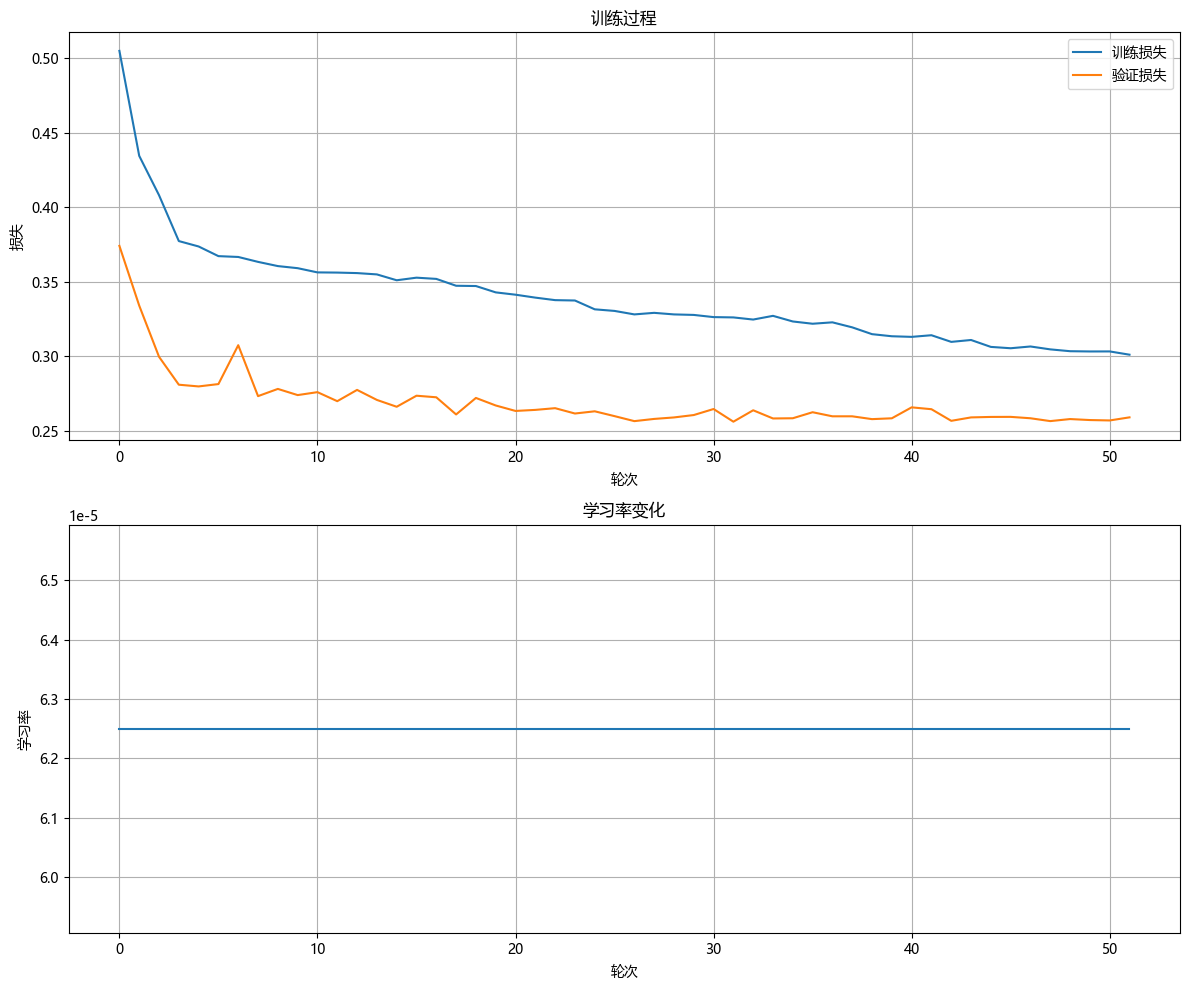


预测结果:
位置: 经度 132.69, 纬度 11.92
台风等级: 9
风速: 21.2 m/s
气压: 998.1 hPa
时间: 10月 17日
降水量: 2.7 mm


In [25]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# 设置中文字体
def set_chinese_font():
    """设置中文字体"""
    try:
        # 优先尝试微软雅黑
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False
        # 测试是否成功
        plt.plot([1, 2, 3], [1, 2, 3])
        plt.title('测试')
        plt.close()
    except:
        try:
            # 尝试黑体
            plt.rcParams['font.sans-serif'] = ['SimHei']
            plt.rcParams['axes.unicode_minus'] = False
        except:
            print("警告: 未能找到合适的中文字体，图表中的中文可能无法正常显示")

# 在文件开始时调用
set_chinese_font()


class TyphoonDataset(Dataset):
    def __init__(self, sequences, targets, sst_data=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.sst_data = sst_data
        
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class TyphoonLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(TyphoonLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        # 添加批标准化
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # 双向LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.0 if num_layers == 1 else dropout,
            bidirectional=True
        )
        
        # 注意力机制
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # 分别处理不同类型的输出
        self.fc_position = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)  # 经度和纬度
        )
        
        self.fc_intensity = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 3)  # 台风等级、风速和气压
        )
        
        self.fc_time = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2),  # 月份和日期
            nn.Sigmoid()  # 确保输出在0-1之间
        )
        
        self.fc_precip = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),  # 降水量
            nn.ReLU()  # 确保降水量非负
        )
        
    def forward(self, x):
        # 应用批标准化
        batch_size, seq_len, features = x.size()
        x = x.view(-1, features)
        x = self.batch_norm(x)
        x = x.view(batch_size, seq_len, features)
        
        # LSTM前向传播
        lstm_out, _ = self.lstm(x)
        
        # 注意力机制
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # 分别处理不同类型的输出
        position = self.fc_position(context_vector)
        intensity = self.fc_intensity(context_vector)
        time = self.fc_time(context_vector)
        precip = self.fc_precip(context_vector)
        
        # 合并所有输出
        output = torch.cat([position, intensity, time, precip], dim=1)
        
        return output

class TyphoonPredictor:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.scaler = StandardScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"使用设备: {self.device}")
        
    def process_precipitation_data(self):
        """处理降水量数据"""
        print("\n处理降水量数据...")
        precip_data = {}
        precip_path = self.data_path / "降水量统计数据"
        
        try:
            for file_path in precip_path.glob("*.csv"):
                try:
                    df = pd.read_csv(file_path, encoding='utf-8')  # 添加编码参数
                    print(f"\n处理文件: {file_path.name}")
                    
                    # 处理日降水量数据
                    if "DailyPrecipitation" in file_path.stem:
                        # 重命名列
                        df.columns = ['年月', '年份', '站点ID', '日期', '降水量']
                        # 转换日期格式
                        df['时间'] = pd.to_datetime(df['日期'], format='%Y-%m-%d', errors='coerce')
                        
                    # 处理最大小时降水量数据
                    elif "MaxHourlyPrecipitation" in file_path.stem:
                        # 提取需要的列并重命名
                        df = df.iloc[:, :5]
                        df.columns = ['年月', '年份', '站点ID', '小时', '降水量']
                        # 构建完整的时间字符串
                        df['时间'] = pd.to_datetime(df['年份'].astype(str) + 
                                                df['年月'].astype(str).str.zfill(2), 
                                                format='%Y%m', errors='coerce')
                        
                    # 处理总降水量数据
                    elif "TotalPrecipitation" in file_path.stem:
                        # 重命名列
                        df.columns = ['年月', '年份', '站点ID', '降水量']
                        # 构建时间
                        df['时间'] = pd.to_datetime(df['年份'].astype(str) + 
                                                df['年月'].astype(str).str.zfill(2), 
                                                format='%Y%m', errors='coerce')
                    else:
                        continue
                    
                    # 转换降水量为数值类型
                    df['降水量'] = pd.to_numeric(df['降水量'], errors='coerce')
                    
                    # 处理缺失值
                    df['降水量'].fillna(0, inplace=True)
                    
                    # 只保留需要的列
                    df = df[['时间', '降水量']].copy()
                    
                    # 筛选1949-2018年的数据
                    mask = (df['时间'].dt.year >= 1949) & (df['时间'].dt.year <= 2018)
                    df = df[mask]
                    
                    if len(df) > 0:
                        precip_data[file_path.stem] = df
                        print(f"成功加载 {len(df)} 条记录")
                        print(f"时间范围: {df['时间'].min()} 到 {df['时间'].max()}")
                        print(f"数据预览:\n{df.head()}\n")
                    
                except Exception as e:
                    print(f"处理文件 {file_path.name} 时出错: {str(e)}")
                    continue
                    
            return precip_data
            
        except Exception as e:
            print(f"处理降水量数据时出错: {str(e)}")
            return None

    def prepare_data(self, sequence_length=10):
        """准备训练数据"""
        print("\n加载台风路径数据...")
        typhoon_data = pd.read_excel(self.data_path / "附件1：中国近海台风路径集合(1945-2023)" / "1945-2023.xlsx")
        
        # 转换时间列为datetime类型
        time_columns = ['台风起始时间', '台风结束时间', '当前台风时间']
        for col in time_columns:
            typhoon_data[col] = pd.to_datetime(typhoon_data[col])
        
        # 筛选1949-2018年的数据
        mask = (typhoon_data['当前台风时间'].dt.year >= 1949) & \
            (typhoon_data['当前台风时间'].dt.year <= 2018)
        typhoon_data = typhoon_data[mask].copy()
        
        print(f"筛选后的台风数据范围: {typhoon_data['当前台风时间'].dt.year.min()}-"
            f"{typhoon_data['当前台风时间'].dt.year.max()}")
        print(f"台风数据记录数: {len(typhoon_data)}")
        
        # 处理基本特征
        features = ['经度', '纬度', '台风等级', '风速', '气压']
        
        # 添加时间特征
        typhoon_data['month'] = typhoon_data['当前台风时间'].dt.month / 12.0
        typhoon_data['day'] = typhoon_data['当前台风时间'].dt.day / 31.0
        features.extend(['month', 'day'])
        
        # 处理降水量数据
        precip_data = self.process_precipitation_data()
        if precip_data:
            print("\n添加降水量特征...")
            typhoon_data['降水量'] = 0.0
            for idx, row in typhoon_data.iterrows():
                time = row['当前台风时间']
                nearest_precip = 0
                for station_data in precip_data.values():
                    if len(station_data) > 0:
                        time_diff = abs(station_data['时间'] - time)
                        if len(time_diff) > 0:
                            nearest_idx = time_diff.argmin()
                            if time_diff[nearest_idx].total_seconds() <= 3600 * 6:
                                nearest_precip = max(nearest_precip, 
                                                station_data.iloc[nearest_idx]['降水量'])
                typhoon_data.at[idx, '降水量'] = nearest_precip
            features.append('降水量')
        
        # 处理缺失值
        for col in features:
            typhoon_data[col].fillna(typhoon_data[col].mean(), inplace=True)
        
        # 标准化数据
        data_scaled = self.scaler.fit_transform(typhoon_data[features].values)
        
        # 创建序列数据
        sequences = []
        targets = []
        
        # 修改这部分代码
        current_idx = 0
        for typhoon_id in typhoon_data['台风编号'].unique():
            typhoon_seq = typhoon_data[typhoon_data['台风编号'] == typhoon_id]
            seq_len = len(typhoon_seq)
            
            if seq_len >= sequence_length + 1:
                # 获取当前台风的数据
                seq_data = data_scaled[current_idx:current_idx + seq_len]
                
                # 创建序列
                for i in range(seq_len - sequence_length):
                    sequences.append(seq_data[i:i+sequence_length])
                    targets.append(seq_data[i+sequence_length])
            
            # 更新索引
            current_idx += seq_len
        
        sequences = np.array(sequences)
        targets = np.array(targets)
        
        print(f"\n准备好的序列数据形状:")
        print(f"输入序列: {sequences.shape}")
        print(f"目标值: {targets.shape}")
        
        return sequences, targets
        
    def create_dataloaders(self, sequences, targets, batch_size=32, train_ratio=0.8):
        """创建训练和验证数据加载器"""
        # 计算训练集大小
        train_size = int(len(sequences) * train_ratio)
        
        # 创建训练集和验证集
        train_sequences = sequences[:train_size]
        train_targets = targets[:train_size]
        val_sequences = sequences[train_size:]
        val_targets = targets[train_size:]
        
        # 创建数据集
        train_dataset = TyphoonDataset(train_sequences, train_targets)
        val_dataset = TyphoonDataset(val_sequences, val_targets)
        
        # 创建数据加载器
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            num_workers=0
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )
        
        print(f"训练集大小: {len(train_sequences)}")
        print(f"验证集大小: {len(val_sequences)}")
        
        return train_loader, val_loader
    
    def custom_loss(self, outputs, targets, features_weights=None):
        """自定义损失函数"""
        if features_weights is None:
            features_weights = torch.ones(outputs.shape[1])
        
        # 计算加权MSE损失
        mse_loss = torch.mean(features_weights * (outputs - targets) ** 2)
        
        # 计算MAE损失
        mae_loss = torch.mean(torch.abs(outputs - targets))
        
        # 对降水量添加额外的非负约束
        precip_loss = torch.mean(torch.relu(-outputs[:, 7])) if outputs.shape[1] > 7 else 0
        
        # 对时间特征添加周期性损失
        time_loss = torch.mean(torch.abs(torch.sin(outputs[:, 5:7] * 2 * np.pi) - 
                                       torch.sin(targets[:, 5:7] * 2 * np.pi)))
        
        return 0.4 * mse_loss + 0.3 * mae_loss + 0.2 * time_loss + 0.1 * precip_loss

    def train_model(self, train_loader, val_loader, input_size, hidden_size=256, 
                   num_layers=2, epochs=100, learning_rate=0.001):
        """训练模型"""
        model = TyphoonLSTM(input_size, hidden_size, num_layers, output_size=input_size)
        model = model.to(self.device)
        
        # 特征权重
        features_weights = torch.tensor([
            2.0, 2.0,  # 经度纬度
            1.5, 1.5, 1.5,  # 台风等级、风速、气压
            1.0, 1.0,  # 月份日期
            2.0  # 降水量
        ]).to(self.device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience = 20
        patience_counter = 0
        
        print("\n增强的训练配置:")
        print(f"初始学习率: {learning_rate}")
        print(f"总轮次: {epochs}")
        print(f"批次大小: {train_loader.batch_size}")
        print(f"模型结构:\n- 隐藏层大小: {hidden_size}\n- LSTM层数: {num_layers}")
        print("使用自定义损失函数")
        print("使用ReduceLROnPlateau学习率调度器")
        
        for epoch in range(epochs):
            # 训练阶段
            model.train()
            train_loss = 0
            for sequences, targets in train_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(sequences)
                loss = self.custom_loss(outputs, targets, features_weights)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # 验证阶段
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for sequences, targets in val_loader:
                    sequences = sequences.to(self.device)
                    targets = targets.to(self.device)
                    outputs = model(sequences)
                    loss = self.custom_loss(outputs, targets, features_weights)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            # 更新学习率
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'scaler': self.scaler
                }, 'best_typhoon_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
            
            if (epoch + 1) % 5 == 0:
                print(f'轮次 [{epoch+1}/{epochs}]')
                print(f'训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}')
                print(f'学习率: {optimizer.param_groups[0]["lr"]:.6f}\n')
            
            if patience_counter >= patience:
                print(f"\n在第 {epoch+1} 轮触发早停")
                break
        
        # 绘制训练过程图
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        # 损失曲线
        axes[0].plot(train_losses, label='训练损失')
        axes[0].plot(val_losses, label='验证损失')
        axes[0].set_xlabel('轮次')
        axes[0].set_ylabel('损失')
        axes[0].set_title('训练过程')
        axes[0].legend()
        axes[0].grid(True)
        
        # 学习率曲线
        lr_history = [group['lr'] for group in optimizer.param_groups for _ in range(len(train_losses))]
        axes[1].plot(lr_history)
        axes[1].set_xlabel('轮次')
        axes[1].set_ylabel('学习率')
        axes[1].set_title('学习率变化')
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return model

    def predict_next_state(self, sequence, model):
        """预测台风的下一个状态"""
        model.eval()
        with torch.no_grad():
            sequence = torch.FloatTensor(sequence).unsqueeze(0).to(self.device)
            prediction = model(sequence)
            
        # 将标准化的预测值转换回原始尺度
        prediction = self.scaler.inverse_transform(prediction.cpu().numpy())
        result = prediction[0]
        
        # 确保降水量非负
        if len(result) > 7:
            result[7] = max(0, result[7])
        
        # 调整月份和日期到合理范围
        result[5] = (result[5] * 12) % 12 + 1  # 1-12月
        result[6] = (result[6] * 31) % 31 + 1  # 1-31日
        
        print("\n预测结果:")
        print(f"位置: 经度 {result[0]:.2f}, 纬度 {result[1]:.2f}")
        print(f"台风等级: {result[2]:.0f}")
        print(f"风速: {result[3]:.1f} m/s")
        print(f"气压: {result[4]:.1f} hPa")
        print(f"时间: {int(result[5])}月 {int(result[6])}日")
        
        if len(result) > 7:
            print(f"降水量: {result[7]:.1f} mm")
        
        return result

# 使用示例
if __name__ == "__main__":
    predictor = TyphoonPredictor("D:/33249/Typhoon-prediction-model")
    
    # 准备数据
    sequences, targets = predictor.prepare_data(sequence_length=10)
    
    # 创建数据加载器
    train_loader, val_loader = predictor.create_dataloaders(
        sequences, 
        targets, 
        batch_size=64,
        train_ratio=0.8
    )
    
    # 训练模型
    input_size = sequences.shape[2]
    model = predictor.train_model(
        train_loader, 
        val_loader, 
        input_size,
        hidden_size=256,
        num_layers=3,
        epochs=100,
        learning_rate=0.001
    )
    
    # 保存训练好的模型
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': predictor.scaler,
        'input_size': input_size,
        'hidden_size': 256,
        'num_layers': 3
    }, 'typhoon_model_final.pth')
    
    # 预测示例
    test_sequence = sequences[0]
    prediction = predictor.predict_next_state(test_sequence, model)